In [46]:
!pip install -q fastplot

In [64]:
import pandas as pd
import os
import fastplot
%matplotlib inline
import numpy as np
from datetime import timedelta, datetime
from decimal import Decimal
from scripts import plot_timeseries

In [48]:
df_nvd_v3 = pd.read_pickle('datasets/epss_v3.pkl')
df_nvd_v3_highest = pd.read_pickle('datasets/epss_v3_highest.pkl')
with open('datasets/cve_info.csv', 'r') as f:
    df_cve_info = pd.read_csv(f)
df_cve_info['published'] = pd.to_datetime(df_cve_info['published'])
current_cve = df_cve_info[df_cve_info['published'] >= '2023-03-07']['id'].values
df_nvd_v3_c = df_nvd_v3[df_nvd_v3['cve'].isin(current_cve)]
df_nvd_v3_c_highest = df_nvd_v3[df_nvd_v3['cve'].isin(df_nvd_v3_highest)]

In [49]:
df_features = pd.DataFrame(columns=['cve', '#daysToT', '#daysDT>0', '#daysDT<=0', 'DT>0_sum', 'DT<=0_sum'])
df_features['cve'] = df_nvd_v3_c['cve'].unique()

# Number of days to reach the threshold

In [50]:
def get_days_before_threshold(series):
    indices_above_threshold = [i for i, v in enumerate(series.values) if v > 0.7]
    return indices_above_threshold[0] if indices_above_threshold else np.nan


def compute_days_needed_to_reach_threshold(df):
    return df.groupby('cve')['epss'].apply(get_days_before_threshold)

In [51]:
df_features['#daysToT'] = df_features['cve'].map(compute_days_needed_to_reach_threshold(df_nvd_v3_c))

# Number of consecutive days with delta-EPSS > (<=) 0 and days up/down

In [52]:
def compute_consecutive_days_feature(df):
    delta_up = 0
    delta_down = 0
    days_up = 0
    days_down = 0
    sorted_dates = sorted(df['date'].unique())
    for date, epss in zip(sorted_dates[1:], df['epss'].iloc[1:]):
        try:
            prev_epss = float(df.loc[df['date'] == date - pd.Timedelta(days=1), 'epss'].values[0])
            if epss > prev_epss:
                days_up += 1
                delta_up += float((epss - prev_epss))
            else:
                days_down += 1
                delta_down += float((epss - prev_epss))
            prev_epss = epss
        except:
            break
    cve = df['cve'].unique()[0]
    df_features.loc[df_features['cve'] == cve, '#daysDT>0'] = days_up
    df_features.loc[df_features['cve'] == cve, '#daysDT<=0'] = days_down
    df_features.loc[df_features['cve'] == cve, 'DT>0_sum'] = round(delta_up, 3)
    df_features.loc[df_features['cve'] == cve, 'DT<=0_sum'] = round(delta_down, 3)
    #return round(delta_up, 2), round(delta_down, 2), days_up, days_down

In [53]:
df_nvd_v3_c.groupby('cve').apply(compute_consecutive_days_feature)

""


In [91]:
len(df_features[df_features['DT<=0_sum'] <= -2.0])

7

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

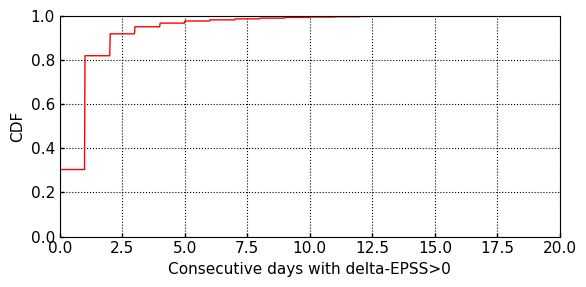

In [72]:
fastplot.plot(df_features['#daysDT>0'].values, None, mode='CDF', grid=True, 
              xlabel='Consecutive days with delta-EPSS>0', figsize=(6, 3))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

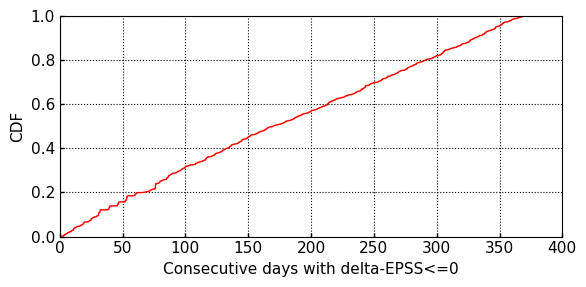

In [71]:
fastplot.plot(df_features['#daysDT<=0'].values, None, mode='CDF', grid=True, 
              xlabel='Consecutive days with delta-EPSS<=0', figsize=(6, 3))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

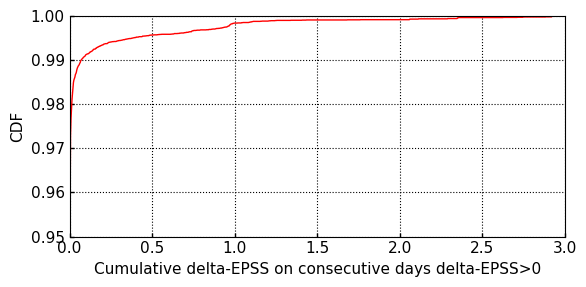

In [70]:
fastplot.plot(df_features['DT>0_sum'].values, None, mode='CDF', ylim=[0.95, 1], grid=True, 
              xlabel='Cumulative delta-EPSS on consecutive days delta-EPSS>0', figsize=(6, 3))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

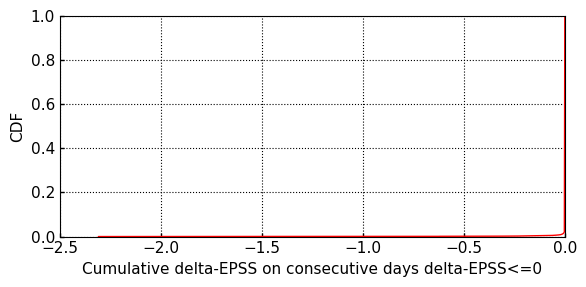

In [74]:
fastplot.plot(df_features['DT<=0_sum'].values, None, mode='CDF', grid=True, 
              xlabel='Cumulative delta-EPSS on consecutive days delta-EPSS<=0', figsize=(6, 3))